### Image Regression

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

In [2]:
path = untar_data(URLs.BIWI_HEAD_POSE)

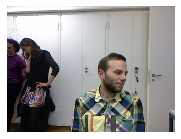

In [11]:
fname =  '09/frame_00667_rgb.jpg'
img = open_image(path / fname)
img.show()

In [7]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6);

def img2txt_name(f): 
    return path/f'{str(f)[:-7]}pose.txt'

def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): 
    return ImagePoints(FlowField(img.size, pts), scale=True)

In [17]:
ctr = get_ctr(fname)
ctr

tensor([263.9104, 428.5814])

In [12]:
img.show?

Signature:
img.show(
    ax: matplotlib.axes._axes.Axes = None,
    figsize: tuple = (3, 3),
    title: Union[str, NoneType] = None,
    hide_axis: bool = True,
    cmap: str = None,
    y: Any = None,
    **kwargs,
)
Docstring: Show image on `ax` with `title`, using `cmap` if single-channel, overlaid with optional `y`
File:      ~/.pyenv/versions/3.8.1/envs/py38/lib/python3.8/site-packages/fastai/vision/image.py
Type:      method


In [16]:
ImagePoints?

Init signature:
ImagePoints(
    flow: fastai.vision.image.FlowField,
    scale: bool = True,
    y_first: bool = True,
)
Docstring:      Support applying transforms to a `flow` of points.
File:           ~/.pyenv/versions/3.8.1/envs/py38/lib/python3.8/site-packages/fastai/vision/image.py
Type:           type
Subclasses:     ImageBBox


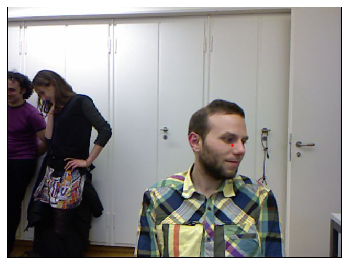

In [18]:
img.show(y=get_ip(img, ctr), figsize=(6, 6))

In [19]:
PointsItemList?

Init signature:
PointsItemList(
    *args,
    convert_mode='RGB',
    after_open: Callable = None,
    **kwargs,
)
Docstring:      `ItemList` for `Image` to `ImagePoints` tasks.
File:           ~/.pyenv/versions/3.8.1/envs/py38/lib/python3.8/site-packages/fastai/vision/data.py
Type:           type
Subclasses:     


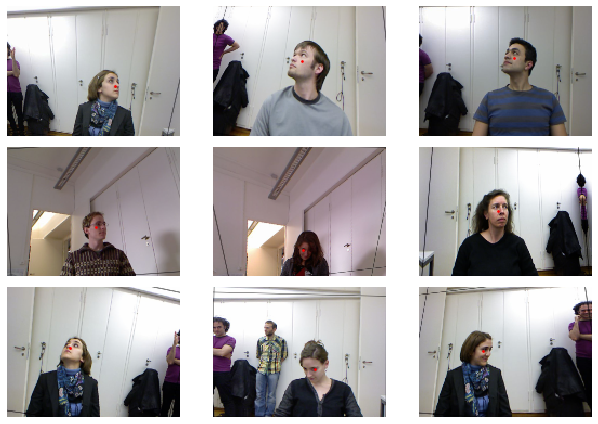

In [20]:
data = (PointsItemList
            .from_folder(path)
            .split_by_valid_func(lambda o: o.parent.name == '13')  # i guess we're using one subdir as valid?
            .label_from_func(get_ctr)  # labels are the points (this is regression)
            .transform(get_transforms(), tfm_y=True, size=(120, 160))
            .databunch()
            .normalize(imagenet_stats))

data.show_batch(3, figsize=(9, 6))

In [22]:
learn = cnn_learner(data, models.resnet34)

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


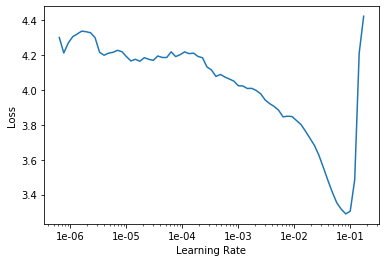

In [24]:
learn.recorder.plot()

In [25]:
lr = 2e-2

In [26]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.129858,0.042582,00:49
1,0.043676,0.007770,00:49
2,0.015346,0.001938,00:49
3,0.008830,0.002253,00:50
4,0.006528,0.001834,00:49


In [27]:
learn.save('stage-1')

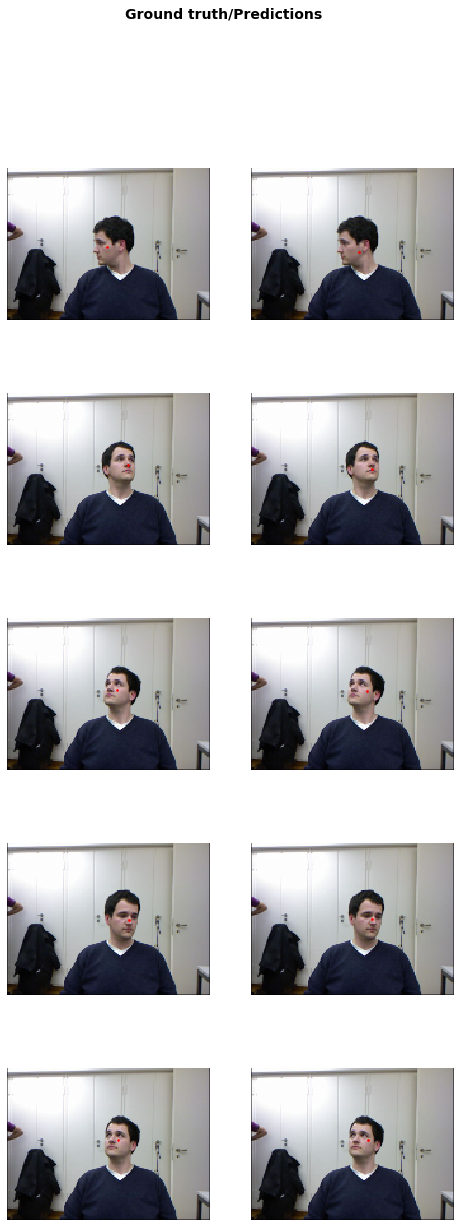

In [28]:
learn.show_results()